In [2]:
# Part 1: Classical Statistics Approach

In [3]:
# import libraries

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

In [4]:
# load crime data from data folder

df = pd.read_csv('../data/raw/crime.csv')
df.head()

,state,murder.rate,poverty,high.school,college,single.parent,unemployed,metropolitan,region
0,Alabama,7.4,14.7,77.5,20.4,26.0,4.6,70.2,South
1,Alaska,4.3,8.4,90.4,28.1,23.2,6.6,41.6,West
2,Arizona,7.0,13.5,85.1,24.6,23.5,3.9,87.9,West
3,Arkansas,6.3,15.8,81.7,18.4,24.7,4.4,49.0,South
4,California,6.1,14.0,81.2,27.5,21.8,4.9,96.7,West


In [5]:
# Check for missing values
print(df.isnull().sum())

state            0
murder.rate      0
poverty          0
high.school      0
college          0
single.parent    0
unemployed       0
metropolitan     0
region           0
dtype: int64


In [ ]:
# just out of curiosity, the summary statistic table:
df.describe()

,murder.rate,poverty,high.school,college,single.parent,unemployed,metropolitan
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,4.604000,11.440000,85.482000,24.932000,22.970000,3.904000,67.726000
std,2.510221,2.937096,3.959782,4.312319,3.038814,0.947383,20.562099
min,0.600000,7.300000,77.100000,15.300000,13.600000,2.200000,27.900000
25%,2.600000,9.425000,82.525000,22.525000,20.950000,3.225000,49.800000
50%,4.550000,10.550000,86.100000,24.450000,22.800000,3.900000,70.250000
75%,6.300000,13.375000,88.175000,27.450000,24.575000,4.400000,84.375000
max,12.500000,19.300000,91.800000,34.600000,30.000000,6.600000,100.000000


In [7]:
# no missing values, so we don't need to "clean" in that respect

# just so we can see the unique variables in the "regions" column

unique_regions = df['region'].unique()
unique_regions

array(['South', 'West', 'Northeast', 'North Central'], dtype=object)

In [8]:
# Create dummy variables for 'region', so we can model & complete ANOVA

df_encoded = pd.get_dummies(df, columns=['region'], drop_first=False)

In [9]:
for col in ['region_North Central', 'region_Northeast', 'region_South', 'region_West']:
    df_encoded[col] = df_encoded[col].astype(int)

In [10]:
# check to make sure it worked

df_encoded.head()

,state,murder.rate,poverty,high.school,college,single.parent,unemployed,metropolitan,region_North Central,region_Northeast,region_South,region_West
0,Alabama,7.4,14.7,77.5,20.4,26.0,4.6,70.2,0,0,1,0
1,Alaska,4.3,8.4,90.4,28.1,23.2,6.6,41.6,0,0,0,1
2,Arizona,7.0,13.5,85.1,24.6,23.5,3.9,87.9,0,0,0,1
3,Arkansas,6.3,15.8,81.7,18.4,24.7,4.4,49.0,0,0,1,0
4,California,6.1,14.0,81.2,27.5,21.8,4.9,96.7,0,0,0,1


In [11]:
# declare variables (drop murder rate and state from X)

X = df_encoded.drop(columns=['murder.rate', 'state'])
y = df_encoded['murder.rate']

In [12]:
# Question 1: Building the Model

In [13]:
# run whole model

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            murder.rate   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9.851
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           9.29e-08
Time:                        22:27:25   Log-Likelihood:                -87.253
No. Observations:                  50   AIC:                             194.5
Df Residuals:                      40   BIC:                             213.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2190 

In [14]:
# Rename columns with dots to underscores
df_encoded = df_encoded.rename(columns=lambda x: x.replace('.', '_'))
df_encoded = df_encoded.rename(columns=lambda x: x.replace(' ', '_'))


# Now your formula should be:
full_model = smf.ols(
    'murder_rate ~ poverty + high_school + college + single_parent + unemployed + metropolitan + region_Northeast + region_South + region_West + region_North_Central',
    data=df_encoded
).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9.851
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           9.29e-08
Time:                        22:27:25   Log-Likelihood:                -87.253
No. Observations:                  50   AIC:                             194.5
Df Residuals:                      40   BIC:                             213.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2190 

In [15]:
print(anova_lm(full_model))

                        df     sum_sq    mean_sq          F    PR(>F)
poverty                1.0  56.224089  56.224089  23.428926  0.000020
high_school            1.0  56.781059  56.781059  23.661019  0.000018
college                1.0   4.386709   4.386709   1.827969  0.183963
single_parent          1.0  46.290252  46.290252  19.289435  0.000080
unemployed             1.0   2.241202   2.241202   0.933923  0.339653
metropolitan           1.0  11.994984  11.994984   4.998384  0.031018
region_Northeast       1.0  31.859914  31.859914  13.276223  0.000765
region_South           1.0   0.098554   0.098554   0.041068  0.840434
region_West            1.0   2.891544   2.891544   1.204924  0.278904
region_North_Central   1.0   1.032929   1.032929   0.430428  0.515535
Residual              40.0  95.990894   2.399772        NaN       NaN


In [16]:
# Reduced model (only single_parent)
model1 = smf.ols('murder_rate ~ single_parent', data=df_encoded).fit()

# model reduced to just single_parent and high_school
model2 = smf.ols('murder_rate ~ single_parent + metropolitan', data=df_encoded).fit()

# model reduced to single_parent, high_school, and poverty
model3 = smf.ols('murder_rate ~ single_parent + metropolitan + high_school', data=df_encoded).fit()


In [17]:
# Compare model 1 and model 2
anova_results = anova_lm(model1, model2)
print(anova_results)

   df_resid         ssr  df_diff    ss_diff         F    Pr(>F)
0      48.0  167.112464      0.0        NaN       NaN       NaN
1      47.0  152.211436      1.0  14.901028  4.601154  0.037149


In [18]:
# Compare model 2 and model 3
anova_results = anova_lm(model2, model3)
print(anova_results)

   df_resid         ssr  df_diff    ss_diff         F    Pr(>F)
0      47.0  152.211436      0.0        NaN       NaN       NaN
1      46.0  136.066296      1.0  16.145141  5.458196  0.023889


In [19]:
# Compare model 1 and model 3
anova_results = anova_lm(model1, model3)
print(anova_results)

   df_resid         ssr  df_diff    ss_diff         F    Pr(>F)
0      48.0  167.112464      0.0        NaN       NaN       NaN
1      46.0  136.066296      2.0  31.046168  5.247897  0.008852


In [20]:
# Compare model 3 and full model
anova_results = anova_lm(model3, full_model)
print(anova_results)

   df_resid         ssr  df_diff    ss_diff         F    Pr(>F)
0      46.0  136.066296      0.0        NaN       NaN       NaN
1      40.0   95.990894      6.0  40.075402  2.783278  0.023409


In [21]:
# get rid of the not statistically significant variables

X_reduced = X[['single.parent', 'metropolitan', 'high.school']]
X_reduced_const = sm.add_constant(X_reduced)

model_reduced = sm.OLS(y, X_reduced_const).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            murder.rate   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     19.46
Date:                Tue, 28 Oct 2025   Prob (F-statistic):           2.73e-08
Time:                        22:27:25   Log-Likelihood:                -95.975
No. Observations:                  50   AIC:                             199.9
Df Residuals:                      46   BIC:                             207.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.3558      8.261      1.133

In [ ]:
# Model 3 explains the greatest amount of variation in murder rate and has the best overall fit among the tested models.
# The ANOVA comparison confirms that the improvements are statistically significant (p < 0.01).
# The other variables that were excluded (poverty, college, unemployed, and regions) are correlated with single parent, metropolitan, and high school. 

In [23]:
# Question 2: Model Diagnostics

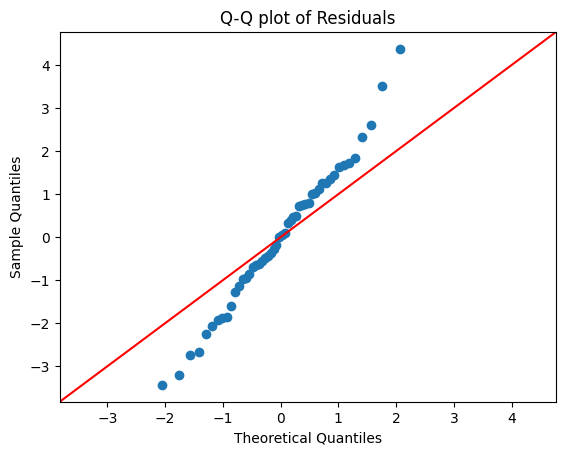

In [24]:
# Q-Q plot of residuals
sm.qqplot(model_reduced.resid, line ='45')
plt.title("Q-Q plot of Residuals")  
plt.show()

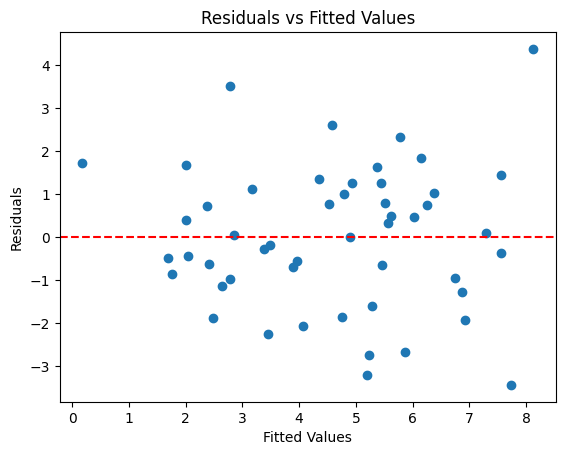

In [25]:
# that looks decently close

# Plot the residuals
plt.scatter(model_reduced.fittedvalues, model_reduced.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

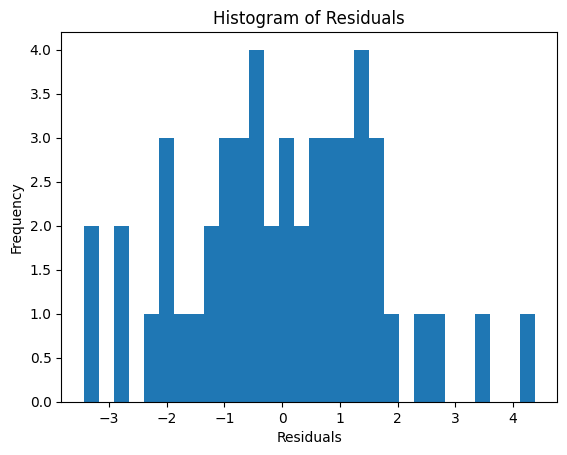

In [26]:
# the residuals seem to be randomly scattered around 0, which is a good sign

# Plot the histogram of residuals
plt.hist(model_reduced.resid, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

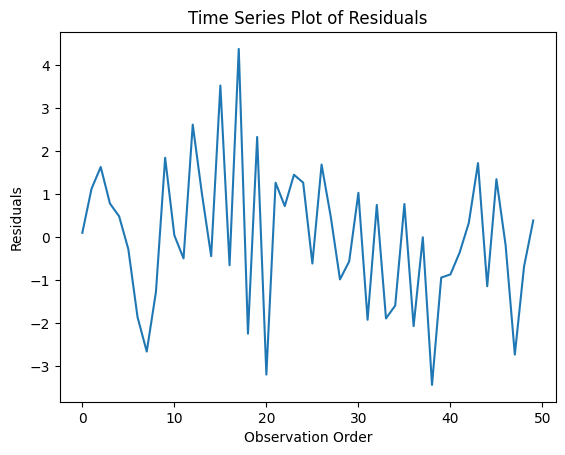

In [27]:
# we only have 50 data points, so it's hard to draw strong conclusions about normality. However, it looks decently normal!

# time series plot of residuals
plt.plot(model_reduced.resid)
plt.title('Time Series Plot of Residuals')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.show()

In [28]:
# The time series also seems to be distributed randomly around 0

# Since no transofrmations were complete, there are no transformation impacts on the model or assumptions.

In [29]:
# caluclate rmse
rmse_full = np.sqrt(np.mean((y - full_model.fittedvalues)**2))
print("RMSE for full model:", rmse_full)

rmse_model3 = np.sqrt(np.mean((y - model3.fittedvalues)**2))
print("RMSE for model3:", rmse_model3)

RMSE for full model: 1.385574924689597
RMSE for model3: 1.649644176815288


In [49]:
# Adjusted R² for your full model
adj_r2_full = full_model.rsquared_adj
print("Adjusted R² for full statsmodels model:", adj_r2_full)

# Adjusted R² for reduced model
adj_r2_reduced = model_reduced.rsquared_adj
print("Adjusted R² for reduced statsmodels model:", adj_r2_reduced)

Adjusted R² for full statsmodels model: 0.6191567906134434
Adjusted R² for reduced statsmodels model: 0.5305720952045672


In [30]:
#Part 2: Machine Learning Approach

In [31]:
np.random.seed(214)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=214)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40, 10) (10, 10) (40,) (10,)


In [32]:
#Question 1: Regression model Analysis with Scikit-learn

In [33]:
# Train a linear regression model for training data
np.random.seed(942)

sk_model = LinearRegression()
sk_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [34]:
# evaluate r^2 on training data
r2_sk_train = sk_model.score(X_train, y_train)
print("R² on train set:", r2_sk_train)

R² on train set: 0.7162247626538154


In [35]:
# Predict on test data
y_pred_test = sk_model.predict(X_test)
r2_sk_test = sk_model.score(X_test, y_test)
print("R² on test set:", r2_sk_test)

R² on test set: 0.2725910727718007


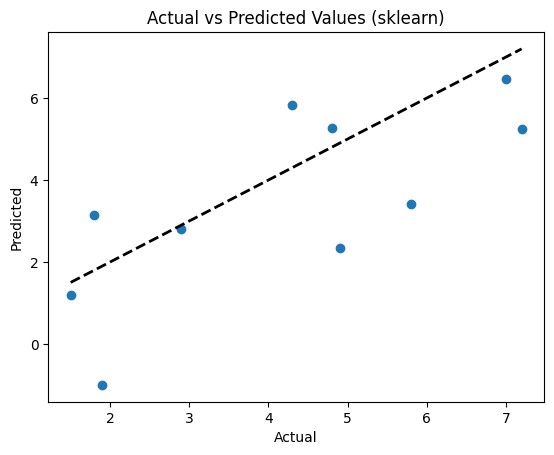

In [36]:
# create a scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (sklearn)')
plt.show()

In [37]:
# having very few data points (50) and splitting in 70/30, these numbers seem pretty decent!

In [44]:
numeric_features = ['poverty', 'high_school', 'college', 'single_parent', 'unemployed', 'metropolitan', 'region_North_Central', 'region_Northeast', 'region_South', 'region_West']
# Create a ColumnTransformer to handle both numeric and categorical (which was already converted into numeric, dummy variables) columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ]
)

In [46]:
#Add random seed for reproducibility
np.random.seed(1122)

#Create a pipeline using sklearn pipeline to impute missing values
pipe = Pipeline([('Scaler', StandardScaler()), ('LR', LinearRegression())])

#Cross validation with KFold
kf=KFold(n_splits=5, shuffle=True, random_state=1122)

#Fit the pipeline using cross validation
scores = cross_val_score(pipe, X_train, y_train, cv=kf)

In [48]:
print("R² scores for each fold:", scores)
print("Average R² score:", np.mean(scores))

R² scores for each fold: [0.08275258 0.24318542 0.70801121 0.15586978 0.57393573]
Average R² score: 0.35275094205763685


In [41]:
# It improved by about 8%, yes!

In [42]:
# Question 2: Model Comparison

#a) 
    # The R squared value for our classical statistical approach, it's duly noted that having a high R squared value for said method suggests that the variables used are
    # well factors for the variation seen in the dependent variables, or in other words it explains why the data is. However, in terms of machine learning, the value is
    # used as an indicator for predicting how well the model actually works, hence prediction power rather than inference from the data. It is typical to use RMSE in the
    # machine learning route to determine how well the model fits the data.

#b)
    # The statistical approach is excellent at providing interpretability for relationships between variables, and digging into the actual explanation of why the data reacts
    # a certain way, and what we can learn from it. Its weaknesses include the fact that it can't rely on heavy data sets, and the actual model in most cases is manual made,
    # which can take time. The machine learning side has a high predictive accuracy, handles large data, and can do any/all tasks automated. In the darker light, the program
    # is treated as a "black box", making it much harder to actually figure out why prediction was made. However, overfitting may occur, as the artificial learning may try to
    # create too good of a model for a singular data set.

#c)
    # In terms of recommendation for the murder analysis, having more specific data, like by State, County, and so forth might be a better "prediction" use, as that we get to
    # see much more data, rather than just generalizing a state. Also, a tableau dashboard of the States vs. other factors may be super beneficial in understanding murder rates
    # from a broader perspective.

In [ ]:
# Discussion

# What do we believe we did well on this assignment? 
    # We successfully implemented both statistical and machine learning approaches to analyze murder rates. Our team carefully followed modeling steps,
    # performed ANOVA comparisons, and validated models with diagnostics and cross-validation. We also researched unfamiliar methods and asked questions when necessary,
    # which strengthened the quality of our analysis.

# What was the most challenging part of this assignment?
    # Interpreting R² values for statsmodels models and validating results was difficult. Dividing tasks fairly among team members was sometimes challenging
    # due to varying experience levels in statistics and data science.

# What would have made this assignment a better experience?  
    # Step-by-step reference resources or example workflows would have made the assignment smoother. Having a mechanism to evaluate individual contributions
    # could ensure equitable teamwork.

# What do we need help with? 
    # Guidance on detecting anomalies in code and data would be useful. Curated references to Python, statsmodels, and scikit-learn would help us troubleshoot
    # and learn more independently.

# Analysis for Policymakers and Researchers
    # Our analysis indicates that variables such as single-parent households, metropolitan status, and high school completion rates are significant predictors of
    # murder rates. Policymakers could focus on targeted social interventions, educational programs, and community resources in high-risk areas to help reduce
    # violent crime. This highlights the importance of socioeconomic and educational policies in crime prevention.

In [ ]:
# Group Dynamics
    # Brenna wrote most code, Dante wrote most questions/answers. 